### Wikiart: Creative Adverserial Network (CAN)

### Load Libraries

In [ ]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils import data
from torch.utils.data import DataLoader
from google.colab import drive
import argparse
import os
from os import walk
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
import sys
import tensorflow as tf
from torch.autograd import Variable


### Mount Google Drive

In [ ]:
# mount drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7mwb57MjeGsdvT-Zy9k49rufQK2izXCf1ABHyh5o51LuRV2KIPRcQ


### Load Metric Modules

In [ ]:
# load inception score metric
inception_path = '/content/drive/MyDrive/neural_networks/modules/inception_score_pytorch'
#!cat '/content/drive/MyDrive/neural_networks/modules/inception_score_pytorch/inception_score.py'
sys.path.append(inception_path)
from inception_score import inception_score
frechet_path = '/content/drive/MyDrive/neural_networks/modules/frechet_inception_distance'
#!cat '/content/drive/MyDrive/neural_networks/modules/frechet_inception_distance/frechet_inception_distance.py'
sys.path.append(frechet_path)
from frechet_inception_distance import frechet_id

### Training Parameters

In [ ]:
num_epochs = 5
batch_size = 64
learning_rate = 1e-4
use_gpu = True
ngpu = 1
img_size = 64
# device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
tolerance = 1e-6
# use smaller wiki art data for testing
use_test_data = True
n_workers = 8

### Load Subset Wikiart Data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


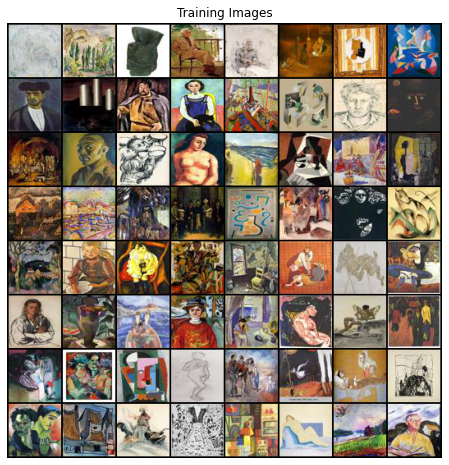

In [ ]:
# print subfolders/art styles of the wikiart subset directory
#!ls '/content/drive/MyDrive/neural_networks/data/wikiart_resized'
# set parent folder of wikiart as file directory
if use_test_data == True:
    data_dir = '/content/drive/MyDrive/neural_networks/data/wikiart_subset'

elif use_test_data == False:
    data_dir = '/content/drive/MyDrive/neural_networks/data/wikiart_resized'

# set random seed
random.seed(1486438)
torch.manual_seed(1486438)

# define transformer for data loader
# resize and normalize data for slight performance boost
img_transform = transforms.Compose([
                                    transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), 
                                                         (0.5, 0.5, 0.5))
                                  ])

dataset = datasets.ImageFolder(root=data_dir,
                           transform=img_transform)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers = n_workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, 
                                         normalize=True).cpu(),(1,2,0)))

### Custom Weight Initialization

In [ ]:
# custom weights initialization called on generator and discriminator
# set random seed
random.seed(1486438)
torch.manual_seed(1486438)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Gan Parameters

In [ ]:
# number of channels (1 = gray, 3 = RGB colors)
nc = 3
# number/size of latent vector z for the generator input
nz = 150
# size/number of feature maps in generator
ngf = 64
# size/number of feature maps in discriminator
# ndf = 64
ndf = 32

# number of art style classes
if use_test_data == True:
  # test wikiart has 5 art style
  n_class = 5
elif use_test_data == False:
  # complete data has 27 art styles
  n_class = 27

# define fixed noise to sample images from the latent space of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# establish convention for real and fake labels 
real_label = 1.
fake_label = 0.

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu=1):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, ngpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            #nn.Conv2d(ndf * 8, ndf * 8, 4, 1, 0, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            #nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.discriminate = nn.Sequential(
            #nn.Linear(ndf * 8, 1),
            #nn.Sigmoid())
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
        self.classify = nn.Sequential(
            nn.Conv2d(ndf * 8, n_class, 4, 1, 0, bias=False)
            #nn.Linear(ndf * 8, 1024),
            #nn.LeakyReLU(0.2),
            #nn.Linear(1024, 512),
            #nn.LeakyReLU(0.2),
            #nn.Linear(512, n_class)
            # nn.Softmax(dim=1))
            )

    def forward(self, input):
        x = self.main(input)
        #x = x.view(x.size(0),-1)
        d_out = self.discriminate(x)
        c_out = self.classify(x)
        return d_out, c_out

generator = Generator()
discriminator = Discriminator()

# apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.02
generator.apply(weights_init)
discriminator.apply(weights_init)

# device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))
print('Generator Architecture:', generator)
print('Discriminator Architecture:', discriminator)

Number of parameters for generator: 3986304 and discriminator: 715136
Generator Architecture: Generator(
  (main): Sequential(
    (0): ConvTranspose2d(150, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d

### Define Storage Location

In [ ]:
# mount google drive for saving checkpoints
drive.mount('/content/drive')

# checkpoint generator file name
gen_save_name = 'wikiart_can_gen.cpt'
# define location to store checkpoints for generator
path_gen = F'/content/drive/MyDrive/neural_networks/checkpoints/{gen_save_name}'

# checkpoint discriminator file name
disc_save_name = 'wikiart_can_disc.cpt'
# define location to store checkpoints for discriminator
path_disc = F'/content/drive/MyDrive/neural_networks/checkpoints/{disc_save_name}'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Train GAN

In [ ]:
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate,
                                 betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate,
                                  betas=(0.5, 0.999))

# store generated images 
img_lst = []
# store generated images for gif
img_lst_gif = []


# loss per iteration
gen_iter_loss = []
disc_iter_loss = []
#loss per epoch
gen_loss_avg = []
disc_loss_avg = []

gen_loss_avg.append(0)
disc_loss_avg.append(0)

entropies = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, style_label) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        #target = target.to(device)
        style_label = style_label.to(device)
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output, output_style = discriminator(real_cpu)
        output = output.reshape(-1)
        # Calculate loss on all-real batch
        disc_loss_real = F.binary_cross_entropy(output, label)
        disc_loss_entropy = F.cross_entropy(output_style.squeeze(), style_label.squeeze())
        # errD_real = F.binary_cross_entropy(output, label)
        # errD_real = errD_real + F.cross_entropy(output_style.squeeze(), style_label.squeeze())
        disc_loss_real = 0.5*(disc_loss_real+disc_loss_entropy)
        # Calculate gradients for D in backward pass
        # errD_real.backward()
        disc_loss_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        # fake = generator(noise)
        fake_image_batch = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output, output_style = discriminator(fake_image_batch.detach())
        output = output.reshape(-1)
        # Calculate D's loss on the all-fake batch
        # errD_fake = criterion(output, label)
        disc_loss_fake = F.binary_cross_entropy(output, label)
        # Calculate the gradients for this batch
        # errD_fake.backward()
        disc_loss_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        # errD = errD_real + errD_fake
        disc_loss = 0.5* (disc_loss_real + disc_loss_fake)
        # Update D
        # optimizerD.step()
        disc_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output, output_style = discriminator(fake_image_batch)
        output = output.reshape(-1)
        # Uniform cross entropy
        logsoftmax = nn.LogSoftmax(dim=1)
        unif = torch.full((data.shape[0], n_class), 1/n_class)
        unif = unif.to(device)
        # Calculate G's loss based on this output
        # errG = criterion(output, label)
        gen_loss = F.binary_cross_entropy(output, label)
        # errG = errG + torch.mean(-torch.sum(unif * logsoftmax(output_style), 1))
        gen_loss = gen_loss + torch.mean(-torch.sum(unif * logsoftmax(output_style), 1))
        # Calculate gradients for G
        # errG.backward()
        gen_loss.backward()
        D_G_z2 = output.mean().item()
        # Update G
        # optimizerG.step()
        gen_optimizer.step()
         
        style_entropy = -1 * (nn.functional.softmax(output_style, dim=1) * nn.functional.log_softmax(output_style, dim=1))
        style_entropy = style_entropy.sum(dim=1).mean() / torch.log(torch.tensor(n_class).float())
        
        # Save Losses for plotting later
        #gen_iter_loss.append(errG.item())
        #disc_iter_loss.append(errD.item())
        gen_iter_loss.append(gen_loss.item())
        disc_iter_loss.append(disc_loss.item())
        entropies.append(style_entropy)

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\t Entropy: %.4f' 
                  % (epoch, num_epochs, i, len(dataloader),
                     #errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, style_entropy))
                     disc_loss.item(), gen_loss.item(), D_x, D_G_z1, D_G_z2, style_entropy))

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_lst.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


No. of sample images stored: [1]
No. of sample images stored: [2]
[0/200][126/1273]	Loss_D: 0.8878	Loss_G: 8.7348	D(x): 0.6887	D(G(z)): 0.0997 / 0.0101	 Entropy: 0.8432
[0/200][253/1273]	Loss_D: 0.7582	Loss_G: 8.7207	D(x): 0.8725	D(G(z)): 0.0417 / 0.0092	 Entropy: 0.8477
[0/200][380/1273]	Loss_D: 0.9977	Loss_G: 5.9640	D(x): 0.5322	D(G(z)): 0.0932 / 0.1463	 Entropy: 0.8531
[0/200][507/1273]	Loss_D: 0.7234	Loss_G: 8.5403	D(x): 0.8051	D(G(z)): 0.0366 / 0.0167	 Entropy: 0.7982
[0/200][634/1273]	Loss_D: 0.6911	Loss_G: 9.2339	D(x): 0.8517	D(G(z)): 0.0823 / 0.0088	 Entropy: 0.7959
[0/200][761/1273]	Loss_D: 0.7745	Loss_G: 7.1379	D(x): 0.6956	D(G(z)): 0.0441 / 0.0646	 Entropy: 0.8031
[0/200][888/1273]	Loss_D: 0.7210	Loss_G: 10.0313	D(x): 0.9682	D(G(z)): 0.0622 / 0.0047	 Entropy: 0.7424
[0/200][1015/1273]	Loss_D: 0.6298	Loss_G: 10.5482	D(x): 0.9275	D(G(z)): 0.0111 / 0.0027	 Entropy: 0.6932
[0/200][1142/1273]	Loss_D: 0.7714	Loss_G: 9.4106	D(x): 0.9062	D(G(z)): 0.1462 / 0.0089	 Entropy: 0.7694
[0/

### Load Checkpoints

In [ ]:
# load models
disc_save_name = 'wikiart_dc_gen.cpt'
gen_save_name = 'wikiart_dc_disc.cpt'

path_gen = F'/content/drive/MyDrive/neural_networks/checkpoints/{gen_save_name}'
path_disc = F'/content/drive/MyDrive/neural_networks/checkpoints/{disc_save_name}'

# check whether checkpoint files exist
if os.path.isfile(path_gen) and os.path.isfile(path_disc) == True:
    checkpoint_gen = torch.load(path_gen)
    checkpoint_disc = torch.load(path_disc)

    # neural net is saved on the gpu we send it to the cpu via .to(device)
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    # given the kernel shut done and all variables are lost
    # optimizers need to be initialised again
    gen_optimizer = torch.optim.Adam(params=generator.parameters(), 
                                     lr=learning_rate, betas=(0.5, 0.999))
    disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), 
                                      lr=learning_rate, betas=(0.5, 0.999))
    generator.load_state_dict(checkpoint_gen['gen_state_dict'])
    discriminator.load_state_dict(checkpoint_disc['disc_state_dict'])
    gen_optimizer.load_state_dict(checkpoint_gen['optimizer_state_dict'])
    disc_optimizer.load_state_dict(checkpoint_disc['optimizer_state_dict'])
    epoch = checkpoint_gen['epoch']
    img_lst = checkpoint_gen['img_lst']
    img_lst_gif = checkpoint_gen['img_lst_gif']
    gen_loss_avg = checkpoint_gen['gen_loss_avg']
    disc_loss_avg = checkpoint_disc['disc_loss_avg']
else: 
    print("Checkpoint files not found or do not exist.")
    print("The neural network may have not been trained yet.")
#model_gen.eval()
# - or -
#model_gen.train()

### Figures: First and Last Image

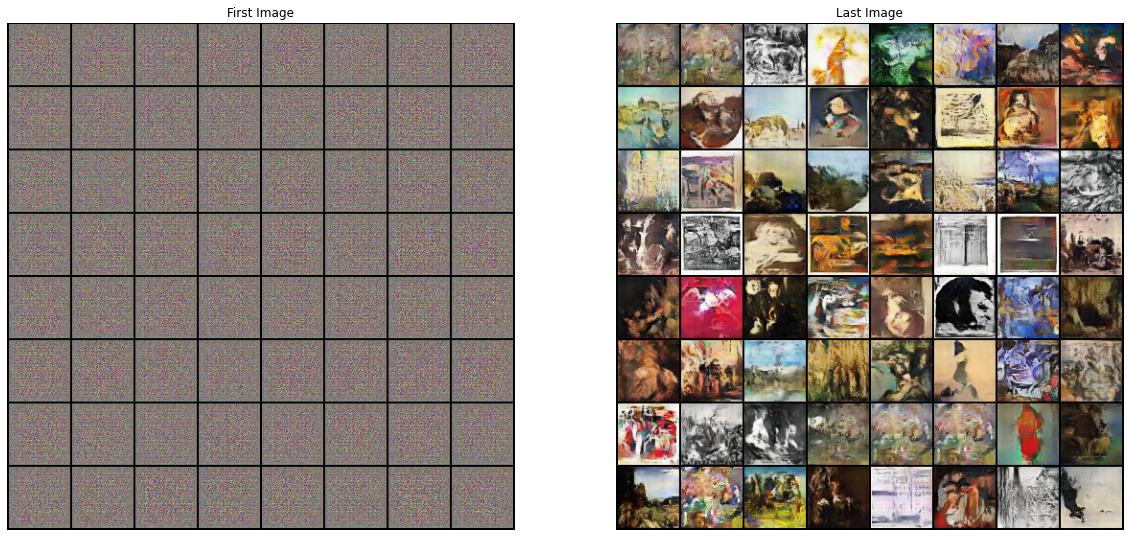

In [ ]:
# plot 1st image
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("First Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
# plot last image
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Last Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[-1].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

### Plot: Real Images vs Generated Images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


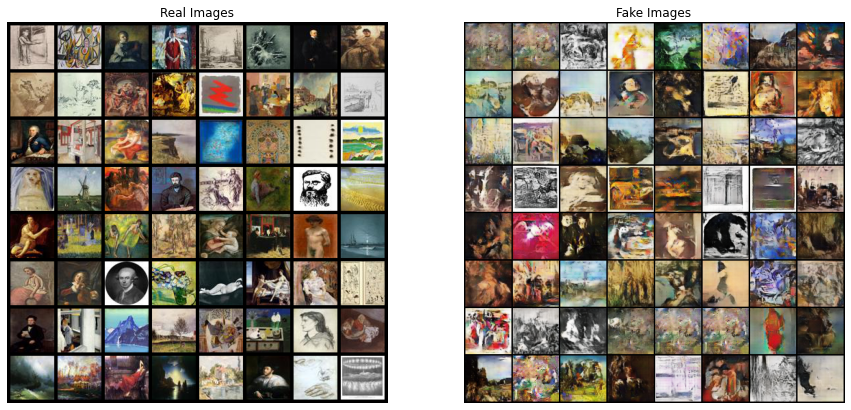

In [ ]:
# Real vs Fake
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_lst[-1],(1,2,0)))
plt.show()

In [ ]:
# Grab a batch of real images from the dataloader
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, 
                                         normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_lst_gif[-1].cpu().numpy(),(1,2,0)))
plt.show()

### Gif: Image Generation Process

In [ ]:
# gif from starting image to last generated image
#%%capture
# if bytes for gif are too big increase limit 
plt.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu().numpy(),(1,2,0)), animated=True)] for i in img_lst_gif]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

### Training Curves

In [ ]:
# Plot average loss per epoch
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
#plt.plot(gen_loss_avg, linewidth=1.5)
#plt.plot(disc_loss_avg, linewidth=1.5)
#plt.title('Average loss per epoch', fontsize = 16)
#plt.xlabel('Number of epochs', fontsize = 16)
#plt.ylabel('Mean Loss', fontsize = 16)
#plt.legend(['Generator', 'Discriminator'], 
#           prop={'size': 14},           
#            frameon=False)

# Plot loss per iteration
plt.subplot(1,2,2)
plt.plot(gen_iter_loss, linewidth=1.5)
plt.plot(disc_iter_loss, linewidth=1.5)
plt.title('Loss per iteration', fontsize = 16)
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.legend(['Generator', 'Discriminator'], 
           prop={'size': 14},           
            frameon=False)
plt.show()

### Image Evaluation Metrics

Inception score

In [ ]:
stedv, means = [], []
imgs = []
for j in range(len(img_lst)):
  for i in range(len(img_lst[j])):
    imgs.append((vutils.make_grid(img_lst[j][i].to(device), padding=2, normalize=True).cpu()))
  if (j % 20 == 0): 
    print('Image metric computed for [%d / %d]' % (j, len(img_lst)))
  mean, stdv = inception_score(imgs, cuda=True, batch_size=32, resize=True, splits=10)
  means.append(mean)
  stedv.append(stdv)

Image metric computed for [0 / 201]


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/content/drive/MyDrive/neural_networks/modules/inception_score_pytorch/inception_score.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).d

Image metric computed for [20 / 201]
Image metric computed for [40 / 201]
Image metric computed for [60 / 201]
Image metric computed for [80 / 201]
Image metric computed for [100 / 201]
Image metric computed for [120 / 201]
Image metric computed for [140 / 201]
Image metric computed for [160 / 201]
Image metric computed for [180 / 201]
Image metric computed for [200 / 201]


Frechet Inception Distance

In [ ]:
real_batch = next(iter(dataloader))
fids = []
for i in range(len(img_lst)):
  fids.append(frechet_id(img_lst[i], real_batch))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Plot average loss per epoch
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(means, linewidth=1.5)
plt.title('Inception score per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Inception score', fontsize = 16)
plt.legend(['IS'], 
           prop={'size': 14},           
            frameon=False)

# Plot loss per iteration
plt.subplot(1,2,2)
plt.plot(fids, linewidth=1.5)
plt.title('Frechet inception distance per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Frechet inception distance', fontsize = 16)
plt.legend(['FID'], 
           prop={'size': 14},           
            frameon=False)
plt.show()

### Store Metrics in txt file

In [ ]:
with open('/content/drive/MyDrive/neural_networks/metric_results/can_is_means.txt','w') as values:
   values.write(str(means))

with open('/content/drive/MyDrive/neural_networks/metric_results/can_fid_means.txt','w') as values:
   values.write(str(fids))

NEvAr Metric

In [ ]:

import tensorflow as tf
# convert pytorch tensor to np array
tensor_to_np = img_lst[110].detach().cpu().numpy()
# convert np array to tf tensor
tf_tensor = tf.convert_to_tensor(tensor_to_np)
# set it as image
img = tf_tensor
# perform tf sobel edge operation
grad_components = tf.image.sobel_edges(img)
# compute gradient magnitute 
grad_mag_components = grad_components**2
# sum magnitude components
grad_mag_square = tf.math.reduce_sum(grad_mag_components,axis=-1)
# sobel edge detected image
grad_mag_img = tf.sqrt(grad_mag_square)
# convert tf tensor to np array
tensor_img = grad_mag_img.numpy()
# plot sobel operaiton on image for testing
#plt.imshow(tensor_img[0][0])

# convert numpy image to pytorch tensor
tensor_img = torch.from_numpy(tensor_img)
# plot using pytorch

# plot original image
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[110][0].to(device), padding=2, 
                                         normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Sobel Operation")
plt.imshow(np.transpose(vutils.make_grid(tensor_img[0][0].to(device), padding=2, 
                                         normalize=True).cpu(),(1,2,0)))

In [ ]:
def grayscale(image):
    grey = np.mean(image, axis = 0)
    return grey
from scipy import ndimage
# image = img_lst[110][0] # single tensor image isolate from batch 
image = img_lst[110][0].detach().cpu().numpy()
image = grayscale(image)
print(image.shape)
#image = grayscale(image)
#image = img_lst[110][0].detach().cpu().numpy()
img_x = ndimage.sobel(image, 0) # sobel operation across horizontal
img_y = ndimage.sobel(image, 1) # sobel operation across vertical
sob = np.hypot(img_x, img_y)
# sob = grayscale(sob)
#sob = np.sum(sob, axis = [-1,-1,-1])
#grad_comp = np.sqrt(img_x + img_y)
#grad_comp = np.sum(grad_comp,axis=-1)
#grad_mag_sqrt = np.sum(grad_comp, axis = -1)
#grad_mag_imge = np.sqrt(grad_mag_sqrt)
#tf.math.reduce_sum(grad_comp,axis=-1)
#image_sobel = np.sqrt((img_x ** 2) + (img_y **2))
# transpose image to obtain correct dimensions
# plot
# plt.imshow(np.transpose(grad_mag_imge,(1,2,0)))
#plt.imshow(np.transpose(grad_comp,(1,2,0)))
plt.imshow(sob, cmap='gray')


In [ ]:
from scipy import ndimage
image = img_lst[110][0] # single tensor image isolate from batch 
#image = grayscale(image)
print(image.shape)
#image = grayscale(image)
#image = img_lst[110][0].detach().cpu().numpy()
img_x = ndimage.sobel(image, 0) # sobel operation across horizontal
img_y = ndimage.sobel(image, 1) # sobel operation across vertical
sob = np.hypot(img_x, img_y)
sob = grayscale(sob)
# sob = np.sum(sob, axis = [-1,-1,-1])
# grad_comp = np.sqrt(img_x + img_y)
# grad_comp = np.sum(grad_comp,axis=-1)
# grad_mag_sqrt = np.sum(grad_comp, axis = -1)
# grad_mag_imge = np.sqrt(grad_mag_sqrt)
# tf.math.reduce_sum(grad_comp,axis=-1)
# image_sobel = np.sqrt((img_x ** 2) + (img_y **2))
# transpose image to obtain correct dimensions
# plot
# plt.imshow(np.transpose(grad_mag_imge,(1,2,0)))
# plt.imshow(np.transpose(grad_comp,(1,2,0)))
plt.imshow(sob, cmap='gray')

### Save singles of generated images

In [ ]:
# stores a single image
#for j in range(len(img_lst)):
#  for i in range(len(img_lst[j])):
#    torchvision.utils.save_image(img_lst[j][i], '/content/drive/MyDrive/neural_networks/wikiart_gen_imgs/%d%d.JPG' % (j,i), normalize = True)
    #imgs.append((vutils.make_grid(img_lst[j][i].to(device), padding=2, normalize=True).cpu()))
#  if (j % 20 == 0): 
#    print('Stores [%d / %d] image batches' % (j * len(img_lst[0]) , len(img_lst[0])* len(img_lst)))